# Trying out on a simple 1-D heat boundary with time dependency

In [7]:
import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf

from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

from mpl_toolkits.mplot3d import Axes3D

We will try the deepXDE on a very simple 1-D heat equation of the following with zero temp at boundary

$
\begin{align}
& \frac{\partial u}{\partial t}  = k \frac{\partial ^2 u}{\partial x^2}  \\
u(x,0) = f(x) \hspace{1em} & u(0,t) = u(L,t) = 0
\end{align}
$

where $f(x) =0.5$

The exact solution is given by:
$u(x,t) = 6 \text{sin} \left( \frac{\pi x}{L} \right) \text{e}^{-k\left(\frac{\pi}{K}\right)^2 t} $

In [8]:
k = 1.22e-3

In [9]:
def pde(x,y):
    
    du_t = dde.grad.jacobian(y, x, j=1)
    du_xx = k * dde.grad.hessian(y, x, j=0)

    return du_t - du_xx 

def func(x):
    return 0.05

geom = dde.geometry.Interval(0, 1)

timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=1000,
    num_boundary=30,
    num_initial=70,
    num_test=10000,
    train_distribution='uniform'
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)
# net.outputs_modify(lambda x, y: x * y)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, loss_weights=[0.1,0.4,0.8])
losshistory, train_state = model.train(epochs=500)


Compiling model...
Building feed-forward neural network...
'build' took 0.061021 s

'compile' took 1.112364 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.92e-02, 1.69e-02, 7.21e-03]    [1.92e-02, 0.00e+00, 0.00e+00]    []  
500       [5.61e-05, 9.38e-05, 8.02e-05]    [5.25e-05, 0.00e+00, 0.00e+00]    []  

Best model at step 500:
  train loss: 2.30e-04
  test loss: 5.25e-05
  test metric: []

'train' took 4.462291 s



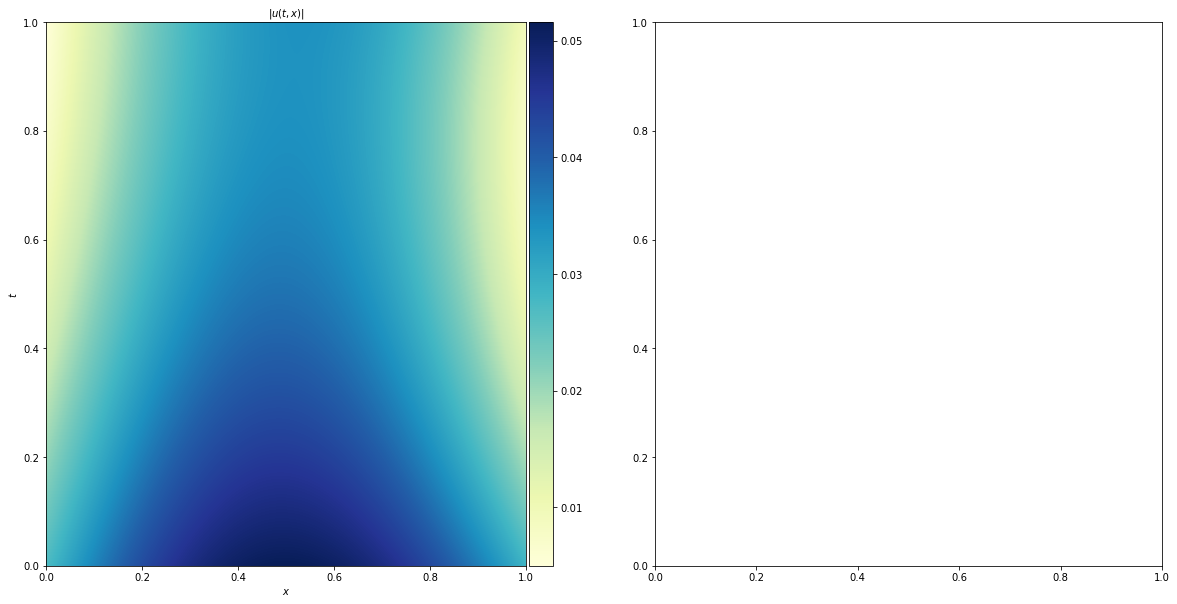

In [11]:
X_train, y_train, X_test, y_test, best_y, best_ystd = train_state.packed_data()
t = X_test.T[0].flatten()
x = X_test.T[1].flatten()
T_points = np.linspace(0, 1, num=best_y.size)
X_points = np.linspace(0, 1, num=best_y.size)
T, X = np.meshgrid(T_points,X_points)

T_pred = griddata(X_test, best_y.flatten(), (X, T), method='cubic')

fig, axs = plt.subplots(ncols=2,figsize=(20, 10))
h = axs[0].imshow(T_pred.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[0, 1, 0, 1], 
                  origin='lower', aspect='auto')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$t$')
axs[0].set_title('$|u(t,x)|$', fontsize = 10)

# Plot analytical solution

# points = np.linspace(0, 1, num=best_y.size)

# def solution(x,t):
#     return 6 * np.sin(np.pi * x)*np.exp(-k*np.pi**2*t)

# z = solution(points,points)

# X_star = np.vstack((points,points)).T

# T_anal = griddata(X_test, z.flatten(), (T, X), method='cubic')

# h = axs[1].imshow(T_anal.T, interpolation='nearest', cmap='YlGnBu', 
#                   extent=[0, 1, 0, 1], 
#                   origin='lower', aspect='auto')

# divider = make_axes_locatable(axs[1])
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(h, cax=cax)
# axs[1].set_xlabel('$x$')
# axs[1].set_ylabel('$t$')
# # leg = ax.legend(frameon=False, loc = 'best')
# #    plt.setp(leg.get_texts(), color='w')
# axs[1].set_title('Analytical Solution', fontsize = 10)
plt.show()

In [13]:

points = np.linspace(0, 1, num=best_y.size)

def solution(x,t):
    return 6 * np.sin(np.pi * x)*np.exp(-k*np.pi**2*t)

z = solution(points,points)

Text(0.5, 0, '$T$')

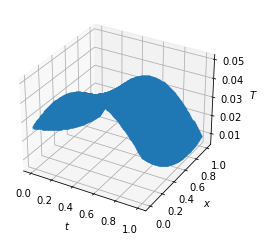

In [12]:
plt.figure()
ax = plt.axes(projection=Axes3D.name)
ax.plot3D(X_test[:, 0], X_test[:, 1], best_y.flatten(), ".")
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.set_zlabel("$T$")